In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
modelstr = "plip" # "tile2vec", "vit_iid","clip","plip"

In [3]:
if modelstr == "tile2vec":
    embed_dict_path = "/home/lofi/lofi/src/outputs_tile2vec/train_sampled_inference_z_embeds.obj"
elif modelstr == "vit_iid":
    embed_dict_path = "/home/lofi/lofi/src/outputs_vit/train_vit_iid_sampled_inference_z_embeds.obj"
elif modelstr == "clip": 
    embed_dict_path = "/home/lofi/lofi/src/outputs_clip/train_clip_sampled_inference_z_embeds.obj"
elif modelstr == "plip":
    embed_dict_path = "/home/lofi/lofi/src/outputs_plip/train_plip_sampled_inference_z_embeds.obj"

In [4]:
from k2 import K2Processor

In [5]:
proc_args = {"datatype":"histo",
        "k":15,
        "quantizer_type":"kmeans",
        "embeddings_path":embed_dict_path,
        "embeddings_type":"dict",
        "mapping_path": None,
        "sample_size":4440,
        "sample_scheme":"random",
        "dataset_path":"/home/data/tinycam/train/train.hdf5",
        "verbosity": "full",
        "so_dict_path": "/home/lofi/lofi/src/outputs/train_so_dict.obj"}
# ViT: "/home/k2/K2/src/outputs_vit/train_vit_iid_chunkid_position.obj"
proc = K2Processor(proc_args)

Embeddings path provided, loading embeddings...


In [6]:
proc.fit_quantizer()

Chosen KMeans model for quantization...
sampled 12 known salient objects!
total embeds: 4440
collapsing from dim 512 --> 2


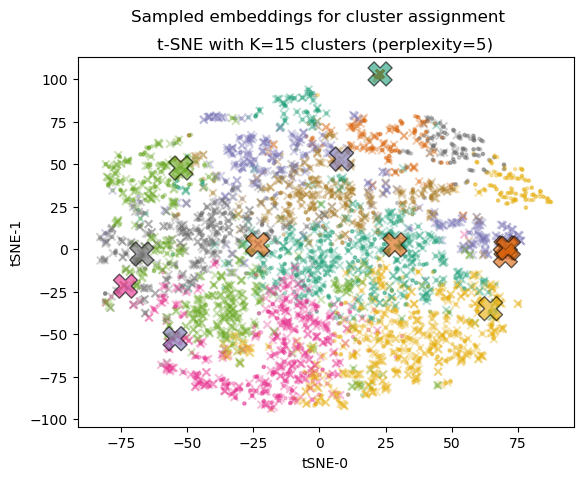

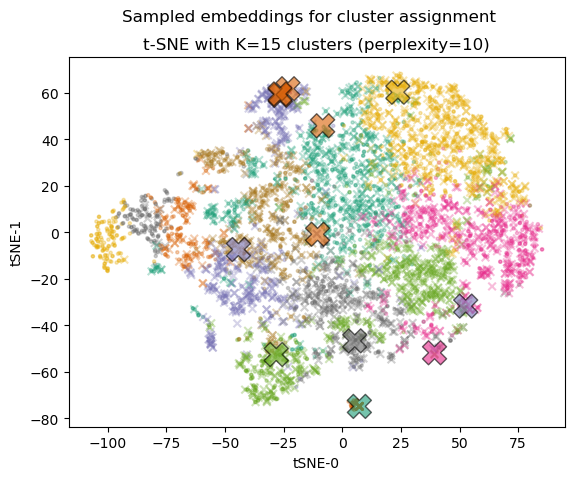

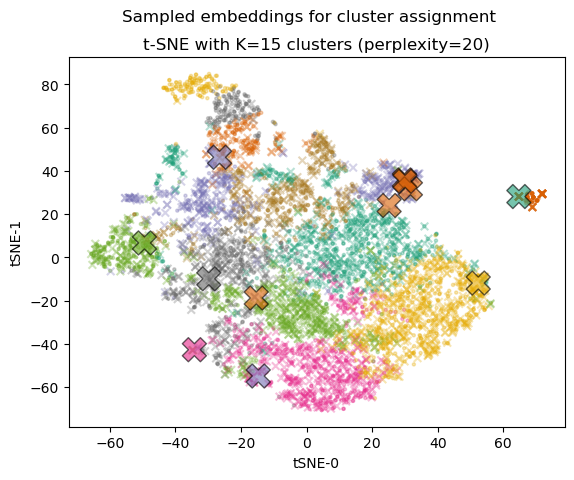

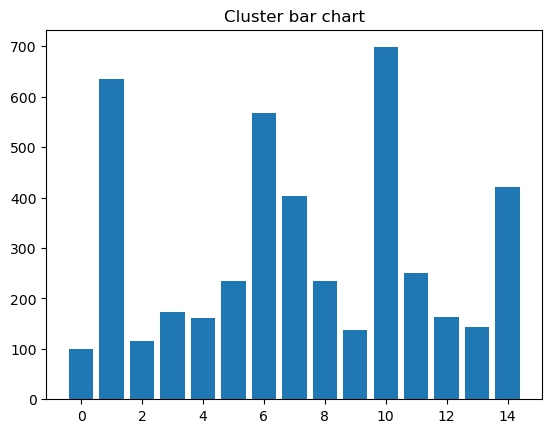

In [7]:
proc.visualize_quantizer()

# Sprite construction

In [8]:
if modelstr == "tile2vec":
    G_dir = "/home/data/tinycam/train/clean_Gs_tile2vec"
elif modelstr == "vit_iid":
    G_dir = "/home/data/tinycam/train/clean_Gs_vit_iid"
elif modelstr == "clip":
    G_dir = "/home/data/tinycam/train/clean_Gs_clip"
elif modelstr == "plip":
    G_dir = "/home/data/tinycam/train/clean_Gs_plip"

In [9]:
import utils
import matplotlib.pyplot as plt
import numpy as np

In [10]:
from utils import visualize_quantizedZ, visualize_Z

In [11]:
crop_coords_dict_path = "/home/lofi/lofi/src/outputs_plip/train_crop_coords.obj" # use plip for all
crop_dict = utils.deserialize(crop_coords_dict_path)

/home/data/tinycam/train/Zs_plip/Z-tumor_045.npy
crop coords: [(0, 123), (34, 89)]


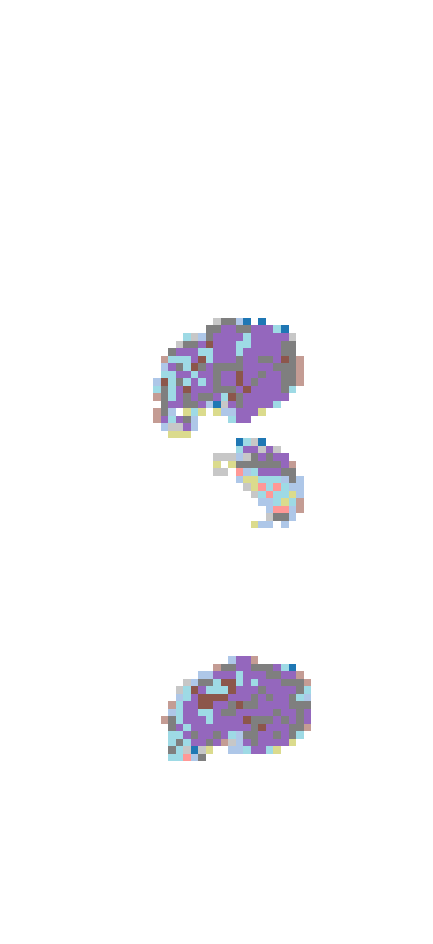

In [12]:
Z_id = "Z-tumor_045.npy"
Z_pathdir = "/home/data/tinycam/train/Zs_" + modelstr

Z_path = Z_pathdir + "/" + Z_id
if modelstr == "vit_iid":
    visualize_Z(Z_path, crop_dict, proc.quantizer, mode="memmap")
else:
    print(Z_path)
    visualize_Z(Z_path, crop_dict, proc.quantizer)

In [13]:
Z = np.load(Z_path)
np.sum(np.sum(Z, axis=(2)) != 0)

520

colors (min, max): 0 14


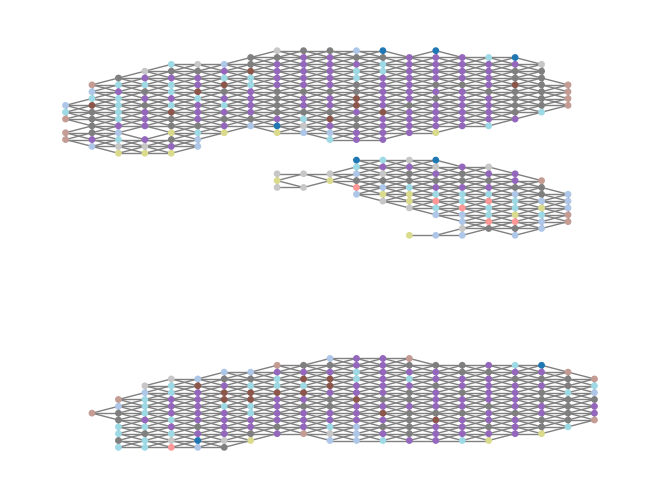

In [14]:
G_id = "G-tumor_045"
G_path = G_dir + "/" + G_id
G = utils.deserialize(G_path)

sprite = utils.construct_sprite(G, proc)
utils.visualize_sprite(sprite, modality="image")

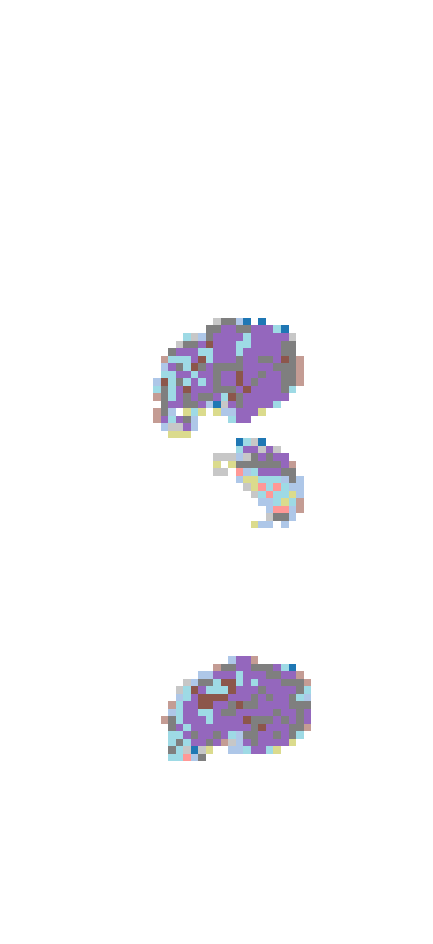

In [15]:
sprite_map = utils.convert_graph2arr(sprite)
visualize_quantizedZ(sprite_map)

In [16]:
from k2 import K2Model

In [17]:
# label_dict = utils.deserialize("/home/data/tinycam/train/" + modelstr + "-label_dict.pkl")
label_dict = utils.deserialize("/home/k2/K2/src/outputs/refined_train_labeldict.obj")
hparams = {"alpha": 0.01, "tau": 1, "lambda": 0.5}
model_args = {"modality":"image",
        "processor":proc,
        "r":2,
        "variant": "inferential",
        "hparams": hparams,
        "train_graph_path": G_dir,
        "train_label_dict": label_dict}

In [18]:
k2m = K2Model(model_args)

In [19]:
k2m.create_train_array()

In [20]:
k2m.fit_kernel()

Differential Expression with alpha,tau: 0.01,1


<BarContainer object of 135 artists>

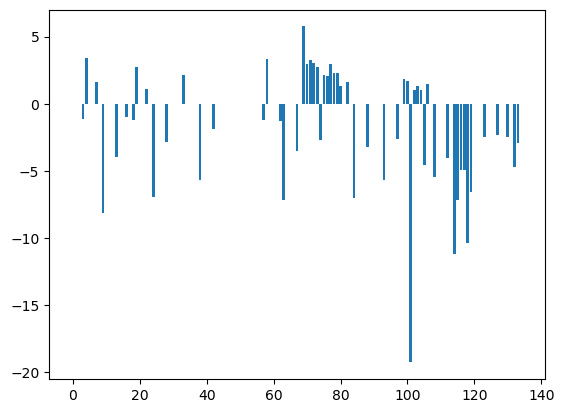

In [21]:
plt.bar(x=range(len(k2m.B)), height=list(k2m.B))

In [22]:
G_file = "/home/data/tinycam/test/Gs_" + modelstr + "/G-test_001"
G = utils.deserialize(G_file)
P = k2m.prospect(G)
print(P)

Graph with 1380 nodes and 5134 edges


Displaying motif graph with log10 scaling


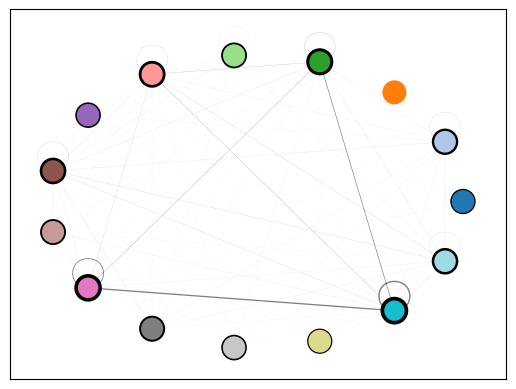

In [23]:
k2m.visualize_motif_graph(G)

No G provided, showing model-wide kernel hash-graph
Displaying motif graph with log2 scaling


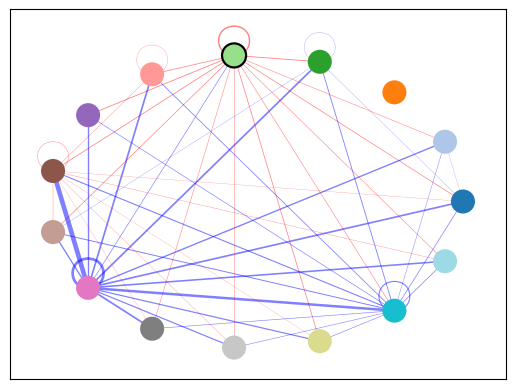

In [24]:
k2m.visualize_motif_graph()

colors (min, max): -313 109


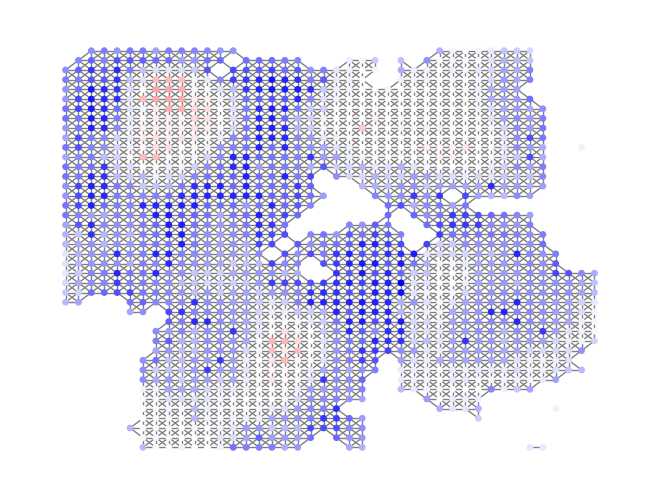

In [25]:
k2m.visualize_prospect_graph(P)

313.1702283832032


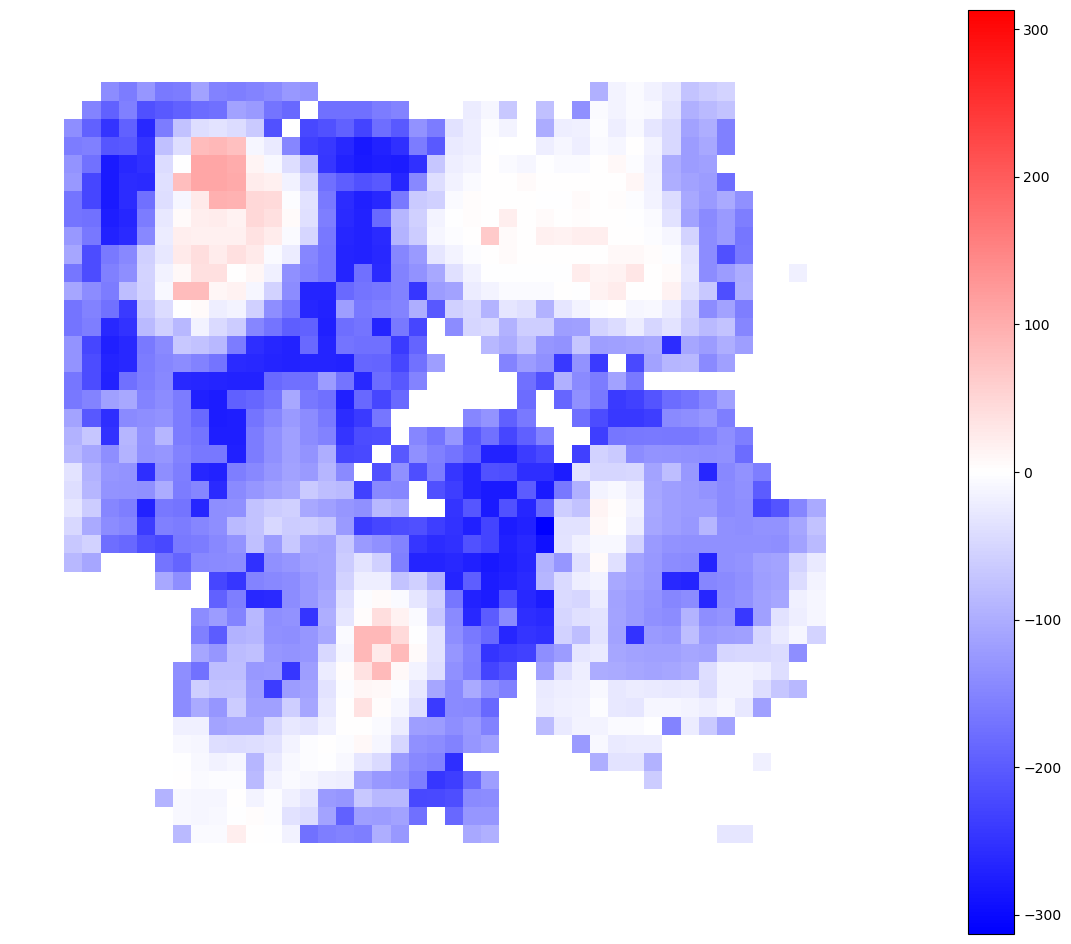

In [26]:
k2m.visualize_prospect_map(P)

In [52]:
# # hyperparameter sweep
# ks = [10,15,20,25,30]
# rs = [0,1,2,4,8]
# alphas = [0.01, 0.025, 0.05, 1e10]
# taus = [0,1,2]

ks = [10,15,20]
rs = [0,1,2]
alphas = [0.01]
taus = [0]
lambdas = [0.5] # keep as elastic

proc_args = {"datatype": "histo",
        "k": None,
        "quantizer_type": "kmeans",
        "embeddings_path": embed_dict_path,
        "embeddings_type": "dict",
        "mapping_path": None,
        "sample_size": 4440,
        "sample_scheme": "random",
        "dataset_path": "/home/data/tinycam/train/train.hdf5",
        "verbosity": "low", # change this to low!
        "so_dict_path": "/home/lofi/lofi/src/outputs/train_so_dict.obj"}

# label_dict = utils.deserialize("/home/data/tinycam/train/" + modelstr + "-label_dict.pkl")
label_dict = utils.deserialize("/home/k2/K2/src/outputs/refined_train_labeldict.obj")
hparams = {"alpha": None, "tau": None, "lambda": None}
model_args = {"modality":"image",
        "processor": None,
        "r": None,
        "variant": "inferential",
        "hparams": hparams,
        "train_graph_path": G_dir,
        "train_label_dict": label_dict}



In [53]:
sweep_dict = {"k": ks, "r": rs, "alpha": alphas, "tau": taus, "lambda": lambdas}
save_dir = "/home/k2/K2/src/outputs/plip_gridsearch"

In [54]:
from evaluation import gridsearch_iteration, train_gridsearch

In [55]:
gt_dir = "/home/data/tinycam/train/gt_graphs"
# model_results_dict, datum_linearized_dict = gridsearch_iteration(k2m, args, gt_dir, thresh="all")

In [56]:
train_gridsearch(sweep_dict, save_dir, modelstr, gt_dir, proc_args, model_args)

No previous results found at: /home/k2/K2/src/outputs/plip_gridsearch/plip-results_dict.obj
Creating new results dictionary...
We have 18 models to train...
...and have 0 models trained so far!
Fitting processor for k=10
Embeddings path provided, loading embeddings...
Chosen KMeans model for quantization...
sampled 12 known salient objects!
Gridsearch: currently on ElasticNet model with k=10, r=0, lam=0.500000
Fitting model for k10_r0_alphanan_taunan_lam0.50.model
Fitting ElasticNet with l1 ratio: 0.5...
Saved model/results!
----------------------------------------
Gridsearch: currently on hypothesis test with k=10, r=0, alpha=0.010000, tau=0.000000
Fitting model for k10_r0_alpha0.010_tau0.00_lamnan.model
Differential Expression with alpha,tau: 0.01,0
Saved model/results!
----------------------------------------
Gridsearch: currently on ElasticNet model with k=10, r=1, lam=0.500000
Fitting model for k10_r1_alphanan_taunan_lam0.50.model
Fitting ElasticNet with l1 ratio: 0.5...
Saved mod

# Inspect results

In [2]:
import utils 
results_dict = utils.deserialize("/home/k2/K2/src/outputs/plip_gridsearch/plip-results_dict.obj")

In [3]:
results_dict

{'k10_r0_alphanan_taunan_lam0.50.model': '/home/k2/K2/src/outputs/plip_gridsearch/plip-eval_results/k10_r0_alphanan_taunan_lam0.50.model',
 'k10_r0_alpha0.010_tau0.00_lamnan.model': '/home/k2/K2/src/outputs/plip_gridsearch/plip-eval_results/k10_r0_alpha0.010_tau0.00_lamnan.model',
 'k10_r1_alphanan_taunan_lam0.50.model': '/home/k2/K2/src/outputs/plip_gridsearch/plip-eval_results/k10_r1_alphanan_taunan_lam0.50.model',
 'k10_r1_alpha0.010_tau0.00_lamnan.model': '/home/k2/K2/src/outputs/plip_gridsearch/plip-eval_results/k10_r1_alpha0.010_tau0.00_lamnan.model',
 'k10_r2_alphanan_taunan_lam0.50.model': '/home/k2/K2/src/outputs/plip_gridsearch/plip-eval_results/k10_r2_alphanan_taunan_lam0.50.model',
 'k10_r2_alpha0.010_tau0.00_lamnan.model': '/home/k2/K2/src/outputs/plip_gridsearch/plip-eval_results/k10_r2_alpha0.010_tau0.00_lamnan.model',
 'k15_r0_alphanan_taunan_lam0.50.model': '/home/k2/K2/src/outputs/plip_gridsearch/plip-eval_results/k15_r0_alphanan_taunan_lam0.50.model',
 'k15_r0_alpha0

In [4]:
model_results = utils.deserialize(results_dict["k10_r0_alphanan_taunan_lam0.50.model"])

In [5]:
model_results

{'G-tumor_072': {'thresh_msd': {0.0: 11.224489795918368,
   0.1: 11.224489795918368,
   0.2: 11.224489795918368,
   0.3: 11.224489795918368,
   0.4: 0.2016326530612245,
   0.5: 0.1058893515764426,
   0.6: 0.1058893515764426,
   0.7: 0.1058893515764426,
   0.8: 0.08677685950413223,
   0.9: 0.08677685950413223,
   1.0: 0,
   ('>', 0.2398265643939414): 11.224489795918368,
   ('<', 0.2398265643939414): 0.048},
  'thresh_cm': {0.0: array([ 28, 522,   4,  26]),
   0.1: array([ 28, 522,   4,  26]),
   0.2: array([ 28, 522,   4,  26]),
   0.3: array([ 28, 522,   4,  26]),
   0.4: array([ 23, 224,   9, 324]),
   0.5: array([ 21, 157,  11, 391]),
   0.6: array([ 21, 157,  11, 391]),
   0.7: array([ 21, 157,  11, 391]),
   0.8: array([ 21, 147,  11, 401]),
   0.9: array([ 21, 147,  11, 401]),
   1.0: array([  0,   0,  32, 548]),
   ('>', 0.2398265643939414): array([ 28, 522,   4,  26]),
   ('<', 0.2398265643939414): array([  4,  26,  28, 522])},
  'cont': {'auroc': 0.6492928832116788,
   'auprc':

In [13]:
from metrics import precision
import metrics

In [14]:
eval("precision([  5, 631,   0,  44])")

0.9348148148148148

In [15]:
exec("metric = precision")

In [16]:
metric

<function metrics.precision(ravel)>

In [18]:
exec("metric = metrics." + "precision")


In [19]:
metric

<function metrics.precision(ravel)>

In [20]:
metric = eval("metrics." + "precision")

In [21]:
metric

<function metrics.precision(ravel)>